In [98]:
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder, label_binarize
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
%matplotlib inline


In [99]:
df_train = pd.read_csv('after1920_train.csv', encoding='ISO 8859-1', dtype='object', index_col=0)
## I created test tests for different time periods using the code in Notebook5

In [100]:
df_train.columns

Index(['adminAction', 'adminActionState', 'authorityDecision1',
       'authorityDecision2', 'caseDisposition', 'caseDispositionUnusual',
       'caseId', 'caseIssuesId', 'caseName', 'caseOrigin', 'caseOriginState',
       'caseSource', 'caseSourceState', 'certReason', 'chief', 'dateArgument',
       'dateDecision', 'dateRearg', 'decisionDirection',
       'decisionDirectionDissent', 'decisionType', 'declarationUncon',
       'docket', 'docketId', 'issue', 'issueArea', 'jurisdiction', 'lawMinor',
       'lawSupp', 'lawType', 'lcDisagreement', 'lcDisposition',
       'lcDispositionDirection', 'ledCite', 'lexisCite', 'majOpinAssigner',
       'majOpinWriter', 'majVotes', 'minVotes', 'naturalCourt', 'partyWinning',
       'petitioner', 'petitionerState', 'precedentAlteration', 'respondent',
       'respondentState', 'sctCite', 'splitVote', 'term', 'threeJudgeFdc',
       'usCite', 'voteId', 'voteUnclear'],
      dtype='object')

I removed a large number of columns because of the following reasons: 
information included in other columns for example docketId, caseIssuesId,and voteId are included in caseId 
information such as the name, id, docket, etc.of a case are also no likely predictive of the outcome
information such as the chief justice, term or naturalCourt are not likely relevant to individual votes
Information that is unavailable until after a decision and is not the target of the model should not be used
Columns with large amounts of missing data were also eliminated. This included the state level information

In [101]:
dropcols = ['docketId', 'caseIssuesId', 'voteId', 'dateDecision',
       'decisionType', 'usCite', 'sctCite', 'ledCite', 'lexisCite', 'term',
            'chief', 'docket', 'caseName', 'dateArgument',
       'dateRearg', 'petitionerState',
       'respondentState', 'jurisdiction', 'adminAction', 'adminActionState',
       'threeJudgeFdc', 'caseOriginState',
       'caseSourceState', 'lcDisagreement', 'certReason', 'lcDisposition',
        'declarationUncon', 'caseDisposition',
       'caseDispositionUnusual', 'partyWinning', 'precedentAlteration',
       'voteUnclear', 'issue',
       'decisionDirectionDissent', 'authorityDecision1', 'authorityDecision2',
       'lawType', 'lawSupp', 'lawMinor', 'majOpinWriter', 'majOpinAssigner',
       'splitVote', 'majVotes', 'minVotes']

for col in dropcols:
    df_train.drop(col, axis=1, inplace=True)




In [102]:
df_train.shape

(11341, 9)

In [103]:
df_train = df_train[df_train.decisionDirection != '3']  ## removing non-political decisions
df_train.dropna(axis=0, inplace=True)


In [104]:
df_train.shape

(10529, 9)

In [105]:
target = 'decisionDirection'
y_train = df_train[target]
X_train = df_train[[col for col in df_train.columns if col != target]]

In [106]:
X_train.describe()

,caseId,caseOrigin,caseSource,issueArea,lcDispositionDirection,naturalCourt,petitioner,respondent
count,10529,10529,10529,10529,10529,10529,10529,10529
unique,10529,137,115,13,3,48,262,250
top,1944-055,302,300,8,1,1103,27,27
freq,1,2295,2047,2992,5686,812,958,1393


Petitioner and Respondent are each categorical valiables with up to 310 categories.  I decided to combine categories based on the frequency of each category and based on the decriptions of each type at http://scdb.wustl.edu/documentation.php along with my subject matter knowledge of law and supreme court decisions. 

I created the speadsheet codelist.csv and a function to reduce the number of categories/
There were only 13 categories of issues, but some occur infrequently so I combined any missing values along with the less frequent cateories into one category: 'misc.' to again reduce the number of categories. 

In [107]:
parties = pd.read_csv("codelist.csv", index_col=None)
def party_categorizer(val):
    if val in parties.State.values:
        return '1'
    elif val in parties.Federal.values:
        return '2'
    elif val in parties.Criminal.values:
        return '3'
    elif val in parties.Liberal.values:
        return '4'
    elif val in parties.RTY.values:
        return '5'
    elif val in parties.Finance.values:
        return '6'
    elif val in parties.Business.values:
        return '7'
    elif val in parties.Political.values:
        return '8'
    elif val in parties.famend.values:
        return '9'
    else:
        return '10'
 

def issue_consolidate(num):
    if num == "None":
        return '13'
    if int(num) in [0, 3, 5, 6, 7, 11, 14]:
        return '13'
    else:
        return str(num)
    
       

Additonally there are 211 categories for case soure an case origin.  I combined these categories into 'state courts' and non-state courts with the lamda functions below. 

In [108]:
X_train.issueArea = X_train.issueArea.apply(lambda x: issue_consolidate(x))
X_train.petitioner = X_train.petitioner.apply(lambda x: party_categorizer(int(x)))                                  
X_train.respondent = X_train.respondent.apply(lambda x: party_categorizer(int(x)))
X_train.caseSource = X_train.caseSource.apply(lambda x :'1' if x in ['300', '301', '301'] else '0')
X_train.caseOrigin = X_train.caseOrigin.apply(lambda x :'1' if x in ['300', '301', '301'] else '0')

/Users/joshuapohl/anaconda/lib/python3.6/site-packages/pandas/core/generic.py:2999: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [109]:
X_train.shape

(10529, 8)

In [110]:
df_test = pd.read_csv('case_test_mod.csv', encoding='ISO 8859-1', dtype='object', index_col=0)
for col in dropcols:
    df_test.drop(col, axis=1, inplace=True) 
df_test = df_test[df_test.decisionDirection != '3']
df_test.dropna(axis=0, inplace=True)
y_test = df_test[target]
X_test = df_test[[col for col in X_train.columns]]
X_test.issueArea = X_test.issueArea.apply(lambda x: issue_consolidate(x))
X_test.petitioner = X_test.petitioner.apply(lambda x: party_categorizer(int(x)))                                  
X_test.respondent = X_test.respondent.apply(lambda x: party_categorizer(int(x)))
X_test.caseSource = X_test.caseSource.apply(lambda x :'1' if x in ['300', '301', '301'] else '0')
X_test.caseOrigin = X_test.caseOrigin.apply(lambda x :'1' if x in ['300', '301', '301'] else '0')

/Users/joshuapohl/anaconda/lib/python3.6/site-packages/pandas/core/generic.py:2999: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [111]:
X_test.shape

(1682, 8)

In [112]:
df_test.shape

(1682, 9)

I decided not to use the justice level voting data for my model.  However, I decided to use the naturalCourt columns that identifies the justices for each case -- and use naturalCourt to create dummy variables for each justice so that the identify of each justice is a feature for my model, although nothing more than the identity. 

In [113]:
judges_old = pd.read_csv('SCDB_Legacy_04_justiceCentered_Citation.csv', encoding='ISO 8859-1', dtype='object', index_col=0)
judges_new = pd.read_csv('justice_train_mod.csv', encoding='ISO 8859-1', dtype='object', index_col=0)

judges = pd.concat([judges_old, judges_new])
judges = judges[['naturalCourt', 'justiceName']]
courtdict = {}
for nc in judges['naturalCourt'].unique():
    courtdict[nc] = [x for x in (judges.loc[judges['naturalCourt'] == nc, :]['justiceName'].unique())]

def justices(key):
    return courtdict[key]


In [114]:
X_train['judgeList'] = X_train.naturalCourt.apply(justices)

In [115]:
X_test['judgeList'] = X_test.naturalCourt.apply(justices)

In [116]:
justice_list = judges.justiceName.unique()

In [117]:
for item in justice_list:
    X_train[item] = X_train.judgeList.apply(lambda x: '1' if item in x else '0')
    X_test[item] = X_test.judgeList.apply(lambda x: '1' if item in x else '0')

 Now that I have dummy variables for each justice, I will drop columns 'naturalCourt' and 'judgeList that I used to generate the dummy variables, but will not use directly.  I will also drop columns that contain redundant information, such as the presence and absence of the same justice. 

In [118]:
X_train.drop(['naturalCourt', 'judgeList'], axis=1, inplace=True)
X_test.drop(['naturalCourt', 'judgeList'], axis=1, inplace=True)


My list of justices (justice_list) includes justices that did not decide any cases during the period (1920-2016) in my training set, so I use the following code to remove the variables for justices that are not in the dataset.

In [119]:
goodcols = [x for x in X_train.describe().iloc[1, :][X_train.describe().iloc[1, :] != 1].index]
X_train = X_train[goodcols]
X_test = X_test[goodcols]

In [120]:
Train_caseID = X_train.caseId
Test_caseID = X_test.caseId
X_train = X_train.iloc[:,1:]
X_test = X_test.iloc[:, 1:]

I use OneHotEndoder to create dummy variables for the cleaned categorical data.

In [121]:
ohc = OneHotEncoder(sparse=False)
ohc.fit(X_train)
X_trainX = ohc.transform(X_train)
X_testX = ohc.transform(X_test)

The data is ready for modelling, but I added the following code after the fact to make interpretation of the encoded data easier. 

In [122]:
fDICT = {}
for i in range(X_train.shape[1]):
    fDICT[ohc.feature_indices_[i]] = X_train.columns[i] + '0'

for k in range(ohc.active_features_[-1]+1):
    if k not in fDICT.keys():
        fDICT[k] = fDICT[k-1][:-1] + str(int(fDICT[k-1][-1]) + 1)

featinx = [x for x in fDICT.keys()]

for i in featinx:
    if i not in ohc.active_features_:
        fDICT.pop(i)

colist = []
for i in ohc.active_features_:
    colist.append(fDICT[i])

train_data = pd.DataFrame(X_trainX)
train_data.columns = colist
test_data = pd.DataFrame(X_testX)
test_data.columns = colist

cols = train_data.columns

keeps = []
for i in range(len(ohc.active_features_)-1):
    if cols[i][:8] == cols[i+1][:8]:
        keeps.append(cols[i])

train_data = train_data[keeps]
test_data = test_data[keeps]

Two of the models that I tried, but did not chose are KNN and Logistic Regression.  My work on these models in Notebook2. I also included my attempts at Gradient Boost and Keras in Notebook3 and Notebook4.  Random Forest provided greater consistent accuracy, so that is the model I chose.  I tuned the hyperparameters using the commented out code below.  I commented this portion out, because the code is slow.

In [123]:
#rfc = RandomForestClassifier(random_state=2017, n_jobs=-1)

In [124]:
# params = {
#     'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120],
#     'max_depth': [12, 13, 14, 15, 16],
#     'criterion': ['gini', 'entropy'],
#     'min_samples_split': [2, 3],
#     'min_samples_leaf': [1, 2, 3]
# }

In [125]:
# gs_rfc = GridSearchCV(rfc, param_grid=params, verbose=1, n_jobs=-1)

In [126]:
# gs_rfc.fit(train_data, y_train)

In [127]:
# gs_rfc.score(test_data, y_test)

In [128]:
# gs_rfc.best_params_

In [129]:
model = RandomForestClassifier(n_estimators=10, min_samples_leaf=2, max_depth=15, random_state=2017)

In [130]:
#y_train = y_train.apply(lambda x: True if x == '2' else False)
#y_test = y_test.apply(lambda x: True if x == '2' else False)

In [131]:
y_trainb = label_binarize(y_train,['1', '2'])

y_testb = label_binarize(y_test,['1', '2'])

In [132]:
model.fit(train_data, y_trainb)

/Users/joshuapohl/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=15, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=2,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=2017,
            verbose=0, warm_start=False)

In [133]:
model.score(train_data, y_trainb)

0.7276094595878051

In [134]:
model.score(test_data, y_testb)

0.643281807372176

Below I create a dataframe with the a column for features and a column for the importance of each feature.  I then sort this dataframe to find the most important features. 

In [135]:
imp_df = pd.DataFrame([train_data.columns, model.feature_importances_]).T

In [136]:
imp_df.columns = ['feature', 'importance']

In [137]:
imp_df['feature'] = imp_df.feature.apply(lambda x: x[:-2] if x[-2] == '1' else x[:-1] )

In [138]:
combo_imp = imp_df.groupby('feature').sum()

In [139]:
combo_imp.features = [x for x in combo_imp.index]

In [140]:
top_features = combo_imp.sort_values('importance', ascending=False).head(10)

In [141]:
top_features.reset_index(inplace=True)

In [142]:
top_features

,feature,importance
0,respondent,0.194822
1,issueArea,0.176424
2,petitioner,0.149601
3,lcDispositionDirection,0.109185
4,caseSource,0.041567
5,WHRehnquist,0.021022
6,JCMcReynolds,0.021000
7,WODouglas,0.019102
8,FFrankfurter,0.014993
9,HABlackmun,0.013559


[<matplotlib.text.Text at 0x1174087f0>, <matplotlib.text.Text at 0x117d0bef0>]

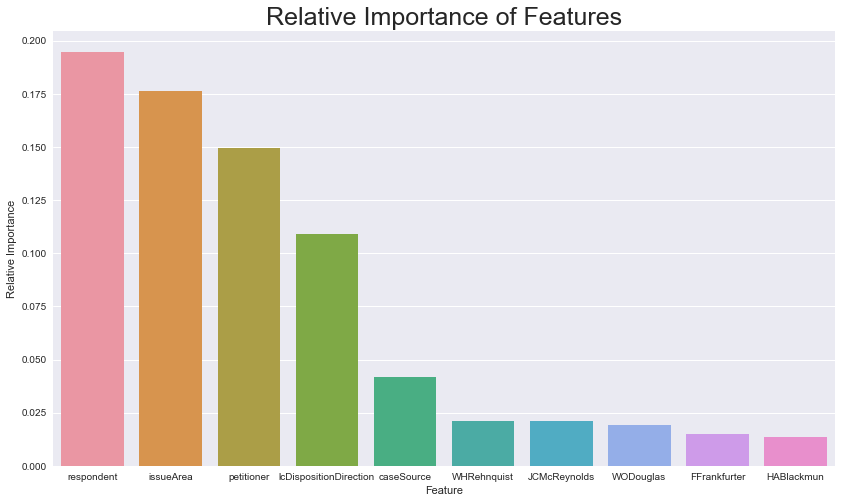

In [143]:
sns.set(style="darkgrid")
fig, ax = plt.subplots()
fig.set_size_inches(14, 8)  
ax.set_title("Relative Importance of Features", fontdict={'fontsize': 25})
ax = sns.barplot(x="feature", y="importance", data=top_features)
ax.set(xlabel='Feature', ylabel='Relative Importance')


Below is code for a Confusion Matrix Visualization

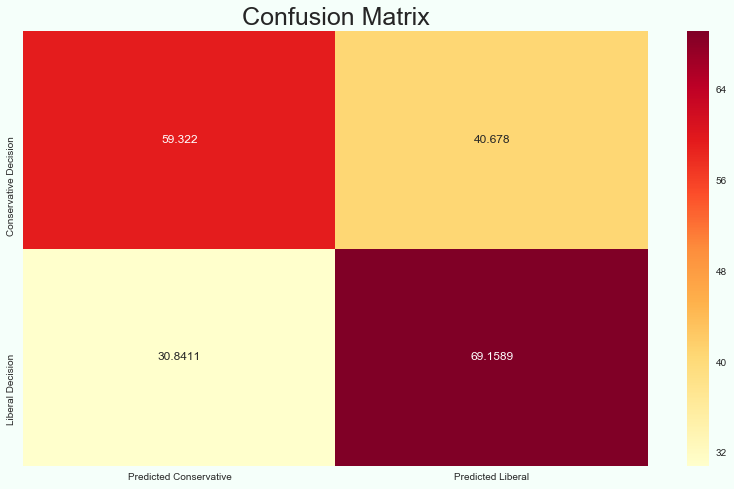

In [194]:
yhat = model.predict(test_data)
conmat = np.array(confusion_matrix(y_testb, yhat))
confusion = pd.DataFrame(conmat, index=['Conservative Decision', 'Liberal Decision'],
                         columns=['Predicted Conservative','Predicted Liberal']).apply(lambda x: 100* x/x.sum(),axis=1)

fig, ax = plt.subplots()
ax.set_title("Confusion Matrix", fontdict={'fontsize': 25})
fig.set_size_inches(14, 8)
fig.patch.set_facecolor('mintcream')
sns.heatmap(confusion, annot=True, fmt='g', cmap='YlOrRd')

The below classification report provides additional metrics for my model

In [195]:
target_names = ['Conservative Direction', 'Liberal Direction']
print(classification_report(y_testb, yhat, target_names=target_names))

                        precision    recall  f1-score   support

Conservative Direction       0.65      0.59      0.62       826
     Liberal Direction       0.64      0.69      0.66       856

           avg / total       0.64      0.64      0.64      1682



### Next Steps

1. Refine Model to include Time-Series information as well as justice level data.  Some research has been performed in this area that measures justices numerically, and I will strongly consider that.
2. Review Feature Selection, since that was the biggest challenge for this model.  
3. Review coding of features -- I may try other types of coding perhaps based on unsupervised learning techniques.
4. Apply the model to 2017 and later cases to see how it performs 


In [147]:
confusion.head()

,Predicted Conservative,Predicted Liberal
Conservative Decision,490,336
Liberal Decision,264,592


In [148]:
results_df = pd.DataFrame()

In [149]:
results_df['outcome'] = y_test

In [150]:
results_df['prediction'] = yhat

In [151]:
results_df.shape

(1682, 2)

In [152]:
len(Test_caseID)

1682

In [153]:
results_df['caseId'] = Test_caseID

In [154]:
results_df.head()

,outcome,prediction,caseId
8,1,0,1946-009
19,1,0,1946-020
20,1,0,1946-021
21,2,1,1946-022
26,2,1,1946-027


In [155]:
mod_case = pd.read_csv('SCDB_2017_01_caseCentered_Citation.csv', encoding='ISO 8859-1', dtype='object')

In [156]:
caseIds = mod_case.caseId
caseNames = mod_case.caseName

In [157]:
caseMap = dict(zip(caseIds, caseNames))

In [158]:
results_df['caseName'] = results_df.caseId.map(caseMap)

In [160]:
mistakes_df = results_df[results_df.outcome != results_df.prediction]

In [161]:
mistakes_df.caseName

8       UNEMPLOYMENT COMPENSATION COMMISSION OF ALASKA...
19      EAGLES, POST COMMANDING OFFICER, v. UNITED STA...
20      EAGLES, POST COMMANDING OFFICER, v. UNITED STA...
21      NATIONAL LABOR RELATIONS BOARD v. A. J. TOWER CO.
26      MACGREGOR v. WESTINGHOUSE ELECTRIC & MANUFACTU...
33       ANDERSON, RECEIVER, v. YUNGKAU, EXECUTOR, ET AL.
45                    ELLIS v. UNION PACIFIC RAILROAD CO.
63            AMERICAN STEVEDORES, INC. v. PORELLO ET AL.
64          AETNA CASUALTY & SURETY CO. ET AL. v. FLOWERS
66      PACKARD MOTOR CAR CO. v. NATIONAL LABOR RELATI...
68      KOSTER v. (AMERICAN) LUMBERMENS MUTUAL CASUALT...
71      KOTCH ET AL. v. BOARD OF RIVER PORT PILOT COMM...
76                                 HAUPT v. UNITED STATES
79            UNITED STATES v. OGILVIE HARDWARE CO., INC.
83      BETHLEHEM STEEL CO. ET AL. v. NEW YORK STATE L...
87                   TRAILMOBILE COMPANY ET AL. v. WHIRLS
90      FLEMING, TEMPORARY CONTROLS ADMINISTRATOR, v. ...
91      FLEMIN

In [246]:
prob_df = pd.DataFrame(model.predict_proba(test_data),columns = ['Conservative', 'Liberal'])
fpr, tpr, thresh = roc_curve(y_testb, prob_df['Liberal'])
roc_auc = auc(fpr, tpr)

In [247]:
prob_df['Conservative'].head()

0    0.607524
1    0.729205
2    0.729205
3    0.437554
4    0.397331
Name: Conservative, dtype: float64

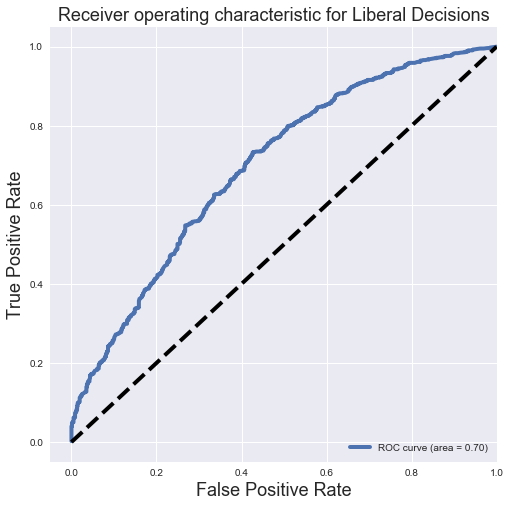

In [248]:
plt.figure(figsize=[8,8])
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc, linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Receiver operating characteristic for Liberal Decisions', fontsize=18)
plt.legend(loc="lower right")